# Imports

In [1]:
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Descriptors
from rdkit.Chem import Draw
from rdkit.Chem.Draw.MolDrawing import MolDrawing,DrawingOptions
DrawingOptions.bondLineWidth=1.8
from rdkit.Chem.EnumerateStereoisomers import EnumerateStereoisomers, StereoEnumerationOptions

import pandas as pd
import re
import requests
from bs4 import BeautifulSoup
from time import sleep
from tqdm import tqdm
import concurrent.futures

# Import Search Results

In [2]:
excel_ws = 'searches2.xlsx'
excel_sheet = 'diarylamines'

compounds_inp = pd.read_excel(excel_ws, sheet_name=excel_sheet)

#generated a reproducible (within this notebook) SMILES string to use later
compounds_inp['Mol Object'] = [Chem.MolFromSmiles(i) for i in compounds_inp['SMILES'].tolist()]
compounds_inp['isoSMILES'] = [Chem.MolToSmiles(i, isomericSmiles=True) for i in compounds_inp['Mol Object'].tolist()]
compounds_inp.set_index(compounds_inp['isoSMILES'], inplace = True)

compounds_smiles_dict = {'master':compounds_inp['SMILES'].tolist()}
print(f'''Imported {len(compounds_smiles_dict['master'])} structures from {excel_ws}''')
compounds_inp

Imported 107612 structures from searches2.xlsx


,Number,SMILES,ZINCID,Database,Mol Object,isoSMILES
isoSMILES,,,,,,
Cn1nnc(Nc2nnn(C)n2)n1,1,Cn1nnc(Nc2nnn(C)n2)n1,ZINC000004834367,In-Stock-19Q4-13.8M,<rdkit.Chem.rdchem.Mol object at 0x00000190DC0...,Cn1nnc(Nc2nnn(C)n2)n1
n1nc(Nc2nn[nH]n2)n[nH]1,2,n1nc(Nc2nn[nH]n2)n[nH]1,ZINC000004575351,In-Stock-19Q4-13.8M,<rdkit.Chem.rdchem.Mol object at 0x00000190DC0...,n1nc(Nc2nn[nH]n2)n[nH]1
n1[nH]nc2c1Nc1nonc1N2,3,n1[nH]nc2c1Nc1nonc1N2,ZINC000001194591,In-Stock-19Q4-13.8M,<rdkit.Chem.rdchem.Mol object at 0x00000190DC0...,n1[nH]nc2c1Nc1nonc1N2
NN1c2nonc2Nc2nonc21,4,NN1c2nonc2Nc2nonc21,ZINC000005510699,In-Stock-19Q4-13.8M,<rdkit.Chem.rdchem.Mol object at 0x00000190DC0...,NN1c2nonc2Nc2nonc21
N#Cc1n[nH]nc1Nc1nonc1N,5,N#Cc1n[nH]nc1Nc1nonc1N,ZINC000001304663,In-Stock-19Q4-13.8M,<rdkit.Chem.rdchem.Mol object at 0x00000190DC0...,N#Cc1n[nH]nc1Nc1nonc1N
...,...,...,...,...,...,...
CCOc1cc(/C=N/NC(=O)Cc2csc(Nc3cccc(C(F)(F)F)c3)n2)ccc1OCc1cccc([N+](=O)[O-])c1,107608,CCOc1cc(/C=N/NC(=O)Cc2csc(Nc3cccc(C(F)(F)F)c3)...,ZINC000408841774,In-Stock-19Q4-13.8M,<rdkit.Chem.rdchem.Mol object at 0x00000190DC8...,CCOc1cc(/C=N/NC(=O)Cc2csc(Nc3cccc(C(F)(F)F)c3)...
COc1cc(/C=N/NC(=O)c2ccc(-c3csc(Nc4ccccc4)n3)cc2)ccc1OCc1ccccc1Cl,107609,COc1cc(/C=N/NC(=O)c2ccc(-c3csc(Nc4ccccc4)n3)cc...,ZINC000409039181,In-Stock-19Q4-13.8M,<rdkit.Chem.rdchem.Mol object at 0x00000190DC8...,COc1cc(/C=N/NC(=O)c2ccc(-c3csc(Nc4ccccc4)n3)cc...
CCOc1cc(/C=N/NC(=O)Cc2csc(Nc3cccc(C(F)(F)F)c3)n2)ccc1OCc1ccc(C)cc1,107610,CCOc1cc(/C=N/NC(=O)Cc2csc(Nc3cccc(C(F)(F)F)c3)...,ZINC000408846085,In-Stock-19Q4-13.8M,<rdkit.Chem.rdchem.Mol object at 0x00000190DC8...,CCOc1cc(/C=N/NC(=O)Cc2csc(Nc3cccc(C(F)(F)F)c3)...


# Simple Filtering (by SMILES strings)

In [3]:
compounds_filtered = compounds_smiles_dict['master']
startlen = len(compounds_filtered)
compounds_filtered = [x for x in compounds_filtered if '@' not in x] #remove chiral compounds
print(f'{startlen - len(compounds_filtered)} chiral compounds removed.'); startlen = len(compounds_filtered)
compounds_filtered = [x for x in compounds_filtered if 'P' not in x] #remove phosphoric acids
print(f'{startlen - len(compounds_filtered)} phosphoric acids removed.'); startlen = len(compounds_filtered)
compounds_filtered = [x for x in compounds_filtered if 'B1O' not in x] #remove boronic esters
print(f'{startlen - len(compounds_filtered)} boronic esters removed.'); startlen = len(compounds_filtered)
compounds_filtered = [x for x in compounds_filtered if 'Si' not in x] #remove silicone containing compounds
print(f'{startlen - len(compounds_filtered)} silicone containing compounds removed.'); startlen = len(compounds_filtered)
compounds_filtered = [x for x in compounds_filtered if '''OB(O)''' not in x] #remove boronic acids
print(f'{startlen - len(compounds_filtered)} boronic acids removed.'); startlen = len(compounds_filtered)
compounds_filtered = [x for x in compounds_filtered if '''C(O)=O''' not in x] #remove carboxylic acids
compounds_filtered = [x for x in compounds_filtered if '''O=C(O)''' not in x]
print(f'{startlen - len(compounds_filtered)} carboxylic acids removed.'); startlen = len(compounds_filtered)
compounds_filtered = [x for x in compounds_filtered if '''[2H]''' not in x] #remove deuterium
print(f'{startlen - len(compounds_filtered)} deuterium containing compounds removed.'); startlen = len(compounds_filtered)
compounds_filtered = [x for x in compounds_filtered if '''[13C]''' not in x] #remove 13C
print(f'{startlen - len(compounds_filtered)} 13C containing compounds removed.'); startlen = len(compounds_filtered)
compounds_filtered = [x for x in compounds_filtered if '''[15N]''' not in x] #remove 15N
print(f'{startlen - len(compounds_filtered)} 15N containing compounds removed.'); startlen = len(compounds_filtered)
print(f'{len(compounds_filtered)} compounds remaining.')

compounds_smiles_dict['simple_filtered'] = compounds_filtered
compounds_smiles_dict['filtered'] = compounds_filtered
compounds_mol_dict = {'master':[Chem.MolFromSmiles(i) for i in compounds_smiles_dict['master']]}
compounds_mol_dict['simple_filtered'] = [Chem.MolFromSmiles(i) for i in compounds_smiles_dict['simple_filtered']]
compounds_mol_dict['filtered'] = [Chem.MolFromSmiles(i) for i in compounds_smiles_dict['simple_filtered']]
#print(compounds_smiles_dict.keys())
#print(compounds_mol_dict.keys())

30007 chiral compounds removed.
50 phosphoric acids removed.
0 boronic esters removed.
7 silicone containing compounds removed.
0 boronic acids removed.
1053 carboxylic acids removed.
0 deuterium containing compounds removed.
0 13C containing compounds removed.
0 15N containing compounds removed.
76495 compounds remaining.


# Advanced Functional Group Filtering (RDKit, SMARTS)

## Definitions (run this cell before filtering)

In [4]:
def find_azides(inp_mols): #find molecules containing azides
    azide = Chem.MolFromSmarts('[$(*-[NX2-]-[NX2+]#[NX1]),$(*-[NX2]=[NX2+]=[NX1-])]')
    azide_mols = []
    for m in inp_mols:
        if m.HasSubstructMatch(azide):
            azide_mols.append(m)
    print(f'Found {len(azide_mols)} compounds containing at least 1 azide')
    return(azide_mols)

def find_phenols(inp_mols): #find molecules containing phenols
    phenol = Chem.MolFromSmarts('[OH]c1ccccc1')
    phenol_mols = []
    for m in inp_mols:
        if m.HasSubstructMatch(phenol):
            phenol_mols.append(m)
    print(f'Found {len(phenol_mols)} compounds containing at least 1 phenol.')
    return(phenol_mols)

def find_multipleamines(inp_mols): #find molecules containing multiple amines (primary/secondary/tertiary)
    amines = Chem.MolFromSmarts('[NX3!$(NC=O);!$(NC=S);!$(NC#N)]')
    multipleamines_mols = []
    for m in inp_mols:
        num_amines = m.GetSubstructMatches(amines)
        if len(num_amines) > 1:
            multipleamines_mols.append(m)
    print(f'Found {len(multipleamines_mols)} compounds with multiple amines.')
    return(multipleamines_mols)

def find_amineandamides(inp_mols):
    amine = Chem.MolFromSmarts('[NX3!$(NC=O);!$(NC=S);!$(NC#N)]')
    amide = Chem.MolFromSmarts('[NX3][CX3](=[OX1])[#6]')
    amineandamide_mols = []
    for m in inp_mols:
        if m.HasSubstructMatch(amine) and m.HasSubstructMatch(amide):
            amineandamide_mols.append(m)
    print(f'Found {len(amineandamide_mols)} compounds with at least 1 amine and 1 amide.')
    return(amineandamide_mols)

def find_arylhalides(inp_mols): #does not include F, uncomment below to include arly fluorides
    arylhalide = Chem.MolFromSmarts('[Cl,Br,I]c1ccccc1')
    #arylhalide = Chem.MolFromSmarts('[F,Cl,Br,I]c1ccccc1')
    arylhalide_mols = []
    for m in inp_mols:
        if m.HasSubstructMatch(arylhalide):
            arylhalide_mols.append(m)
    print(f'Found {len(arylhalide_mols)} compounds with at least 1 aryl halide (not including F).')
    return(arylhalide_mols)

def find_alkylhalides(inp_mols):
    alkylhalide = Chem.MolFromSmarts('[F,Cl,Br,I]C')
    alkylhalide_mols = []
    for m in inp_mols:
        if m.HasSubstructMatch(alkylhalide):
            alkylhalide_mols.append(m)
    print(f'Found {len(alkylhalide_mols)} compounds with at least 1 alykl halide.')
    return(alkylhalide_mols)

def find_nitros(inp_mols): #hits both forms
    nitro = Chem.MolFromSmarts('[$([NX3](=O)=O),$([NX3+](=O)[O-])][!#8]')
    
def find_noxides(inp_mols): #won't hit azoxy, nitro, nitroso, or nitrate
    noxide = Chem.MolFromSmarts('[$([#7+][OX1-]),$([#7v5]=[OX1]);!$([#7](~[O])~[O]);!$([#7]=[#7])]')
    
def find_nitrosos(inp_mols):
    nitroso = Chem.MolFromSmarts('[NX2]=[OX1]')
    
def find_hydrazinse(inp_mols):
    hydrazine = Chem.MolFromSmarts('[NX3][NX3]')
    
def find_hydrazones(inp_mols):
    hydrazone = Chem.MolFromSmarts('[NX3][NX2]=[*]')
    
def find_aldehydes(inp_mols):
    aldehyde = Chem.MolFromSmarts('[CX3H1](=O)[#6]')
    aldehyde_mols = []
    for m in inp_mols:
        if m.HasSubstructMatch(aldehyde):
            aldehyde_mols.append(m)
    print(f'Found {len(aldehyde_mols)} compounds with at least 1 aldehyde.')
    return(aldehyde_mols)
    
def find_oximes(inp_mols): #hits aldoximes and ketoximes
    oxime = Chem.MolFromSmarts('[CX3]=[NX2][OH]')
    oxime_mols = []
    for m in inp_mols:
        if m.HasSubstructMatch(oxime):
            oxime_mols.append(m)
    print(f'Found {len(oxime_mols)} compounds with at least 1 oxime.')    
    return(oxime_mols)

def find_sulferacids(inp_mols):
    sulfonicacid = Chem.MolFromSmarts('[$([#16X4](=[OX1])(=[OX1])([#6])[OX2H,OX1H0-]),$([#16X4+2]([OX1-])([OX1-])([#6])[OX2H,OX1H0-])]')
    sulfinicacid = Chem.MolFromSmarts('[$([#16X3](=[OX1])[OX2H,OX1H0-]),$([#16X3+]([OX1-])[OX2H,OX1H0-])]')
    sulfamicacid = Chem.MolFromSmarts('[$([#16X4]([NX3])(=[OX1])(=[OX1])[OX2H,OX1H0-]),$([#16X4+2]([NX3])([OX1-])([OX1-])[OX2H,OX1H0-])]')
    sulfenicacid = Chem.MolFromSmarts('[#16X2][OX2H,OX1H0-]')
    sulferacid_mols = []
    for m in inp_mols:
        if  m.HasSubstructMatch(sulfonicacid) or m.HasSubstructMatch(sulfinicacid) or m.HasSubstructMatch(sulfamicacid) or m.HasSubstructMatch(sulfenicacid):
            sulferacid_mols.append(m)
    print(f'Found {len(sulferacid_mols)} compounds with at least 1 acidic sulfer moiety.')
    return(sulferacid_mols)
    
    

## Filtering

In [5]:
#Functional Groups to Filter, comment lines you do not wish to exclude
to_filter = [
    'azides',
    'phenols',
    'multipleamines',
    'arylhalides',
    'aldehydes',
    'oximes',
    'sulferacids',
    "amineandamides",
]

#imports structures in case simple filtering has not been used
try: startlen = len(compounds_mol_dict['filtered'])
except: 
    compounds_mol_dict['filtered'] = [Chem.MolFromSmiles(i) for i in compounds_smiles_dict['master']]
    compounds_smiles_dict['filtered'] = compounds_smiles_dict['master']
    
#generate dictionary of functional groups
compounds_mol_dict['azides'] = find_azides(compounds_mol_dict['filtered'])
compounds_mol_dict['phenols'] = find_phenols(compounds_mol_dict['filtered'])
compounds_mol_dict['multipleamines'] = find_multipleamines(compounds_mol_dict['filtered'])
compounds_mol_dict['arylhalides'] = find_arylhalides(compounds_mol_dict['filtered'])
compounds_mol_dict['alkylhalides'] = find_alkylhalides(compounds_mol_dict['filtered'])
compounds_mol_dict['aldehydes'] = find_aldehydes(compounds_mol_dict['filtered'])
compounds_mol_dict['oximes'] = find_oximes(compounds_mol_dict['filtered'])
compounds_mol_dict['sulferacids'] = find_sulferacids(compounds_mol_dict['filtered'])
compounds_mol_dict['amineandamides'] = find_amineandamides(compounds_mol_dict['filtered'])

#filter based on selected functional groups
start_len = len(compounds_mol_dict['filtered'])

for fg in tqdm(to_filter):
    compounds_mol_dict['filtered'] = [m for m in compounds_mol_dict['filtered'] if m not in compounds_mol_dict[fg]]
            
end_len = len(compounds_mol_dict['filtered'])

print(f'\n{start_len - end_len} compounds removed according to selected filters.')
print(f'{end_len} compounds remaining in current selection.')
    

#print(compounds_mol_dict.keys())

Found 4 compounds containing at least 1 azide
Found 2932 compounds containing at least 1 phenol.
Found 32226 compounds with multiple amines.
Found 20039 compounds with at least 1 aryl halide (not including F).
Found 5475 compounds with at least 1 alykl halide.
Found 142 compounds with at least 1 aldehyde.
Found 38 compounds with at least 1 oxime.
Found 298 compounds with at least 1 acidic sulfer moiety.
Found 24343 compounds with at least 1 amine and 1 amide.


100%|██████████| 8/8 [00:32<00:00,  4.04s/it]


58488 compounds removed according to selected filters.
18007 compounds remaining in current selection.


## Preview Results (optional)

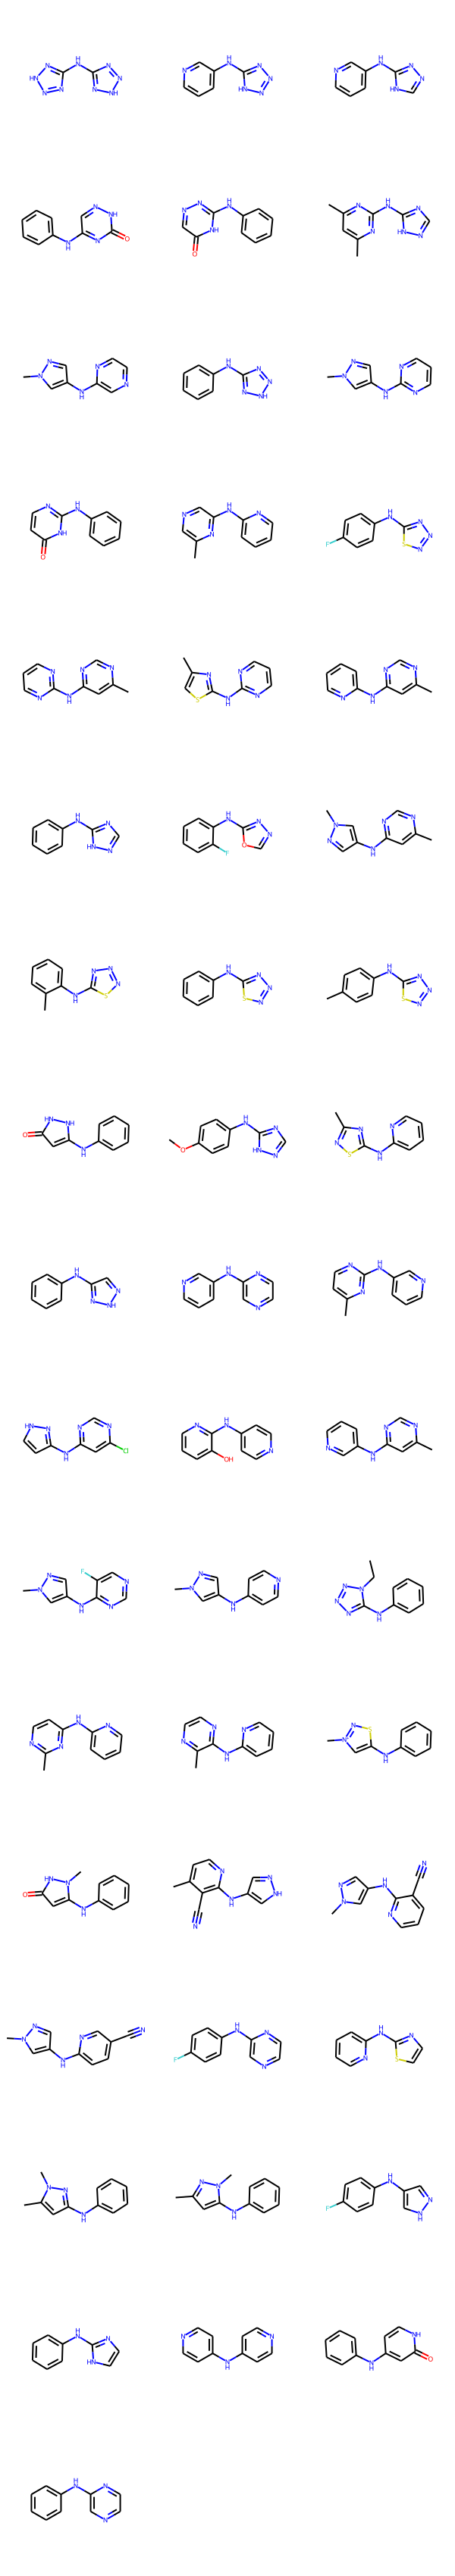

In [6]:
#print the first 50
template = Chem.MolFromSmiles('C1(NC2=CC=CC=C2)=CC=CC=C1')
AllChem.Compute2DCoords(template)
ms = compounds_mol_dict['filtered'][1:50]
Draw.MolsToGridImage(ms)

## Organize Results

In [7]:
#place data in dataframe along with accompanying ZINCID
filtered_df = pd.DataFrame
filtered_smiles_list = [Chem.MolToSmiles(m, isomericSmiles=True) for m in compounds_mol_dict['filtered']]
filtered_df = pd.DataFrame()
filtered_df['SMILES'] = filtered_smiles_list
filtered_zincid_list = []
for m in filtered_df['SMILES'].tolist():
    filtered_zincid_list.append(compounds_inp.loc[m]['ZINCID'])
filtered_df['ZINCID'] = filtered_zincid_list
filtered_df


,SMILES,ZINCID
0,Cn1nnc(Nc2nnn(C)n2)n1,ZINC000004834367
1,n1nc(Nc2nn[nH]n2)n[nH]1,ZINC000004575351
2,c1cncc(Nc2nnn[nH]2)c1,ZINC000095234858
3,c1cncc(Nc2nnc[nH]2)c1,ZINC000225807495
4,O=c1nc(Nc2ccccc2)cn[nH]1,ZINC000002697980
...,...,...
18002,CCCCCCCCCCCCC1(CCCCCCCCCCCC)c2ccccc2Nc2ccccc21,ZINC001857794222
18003,FC(F)(Cl)Oc1ccc(Nc2nc(OC(C(F)(F)F)C(F)(F)F)nc(...,ZINC000100105460
18004,Cc1cc(C)n(-c2nc(Nc3cccc(C(F)(F)F)c3)nc(OC(C(F)...,ZINC000033353331
18005,Cc1cccn2c(=O)c(/C=N/c3ccc(S(=O)(=O)c4cccc(C(F)...,ZINC000097983857


# Search Commercial Availability

## Definitions

In [8]:
#To add new vendors: you must add information in the 3 places below: name, url_pattern, and cat_pattern
#nothing else needs changing

#list of vendors as they would appear on a ZINC substance page
vendors = {}
vendors['names'] = [
    'Combi-Blocks',
    'Matrix Scientific',
    'AK Scientific',
    'Enamine', #building blocks only, no make-on-demand
    'AstaTech',
    'Sigma Aldrich',
    'Alfa Aesar',
    'AmBeed',
    #'Acros',
    'aaBlocks',
    'AChemBlock',
    'ChemImpex',
    'BioSynth' #same as carbosynth
]

vendors['url_patterns'] = []
#regex expressions for URL capture, must be in same order as vendor list above
combi_blocks_url_pattern = re.compile('https?:\/\/(?:www\.)?combi-blocks\.com\/\S*'); vendors['url_patterns'].append(combi_blocks_url_pattern)
matrix_scientific_url_pattern = re.compile('https?:\/\/(?:www\.)?matrixscientific\.com\/\S*'); vendors['url_patterns'].append(matrix_scientific_url_pattern)
ak_scientific_url_pattern = re.compile('http[s]?:\/\/[www\.]?aksci\.com\/\S*'); vendors['url_patterns'].append(ak_scientific_url_pattern)
enamine_url_pattern = re.compile('https?:\/\/(?:www\.)?enaminestore\.com\/.*(?:\/EN)\S*'); vendors['url_patterns'].append(enamine_url_pattern)
astatech_url_pattern = re.compile('https?:\/\/(?:www\.)?astatechinc\.com\/\S*'); vendors['url_patterns'].append(astatech_url_pattern)
sigma_aldrich_url_pattern = re.compile('https?:\/\/(?:www\.)?sigmaaldrich\.com\/catalog\/search\?term=\w+[^|]+\w+'); vendors['url_patterns'].append(sigma_aldrich_url_pattern)
alfa_aesar_url_pattern = re.compile('https?:\/\/(?:www\.)?alfa\.com\S*'); vendors['url_patterns'].append(alfa_aesar_url_pattern)
ambeed_url_pattern = re.compile('https?:\/\/(?:www\.)?ambeed\.com\/\S*'); vendors['url_patterns'].append(ambeed_url_pattern)
#acros_url_pattern = re.compile(''); vendors['url_patterns'].append(acros_url_pattern)
aablocks_url_pattern = re.compile('https?:\/\/(?:www\.)?aablocks\.com\/\S*'); vendors['url_patterns'].append(aablocks_url_pattern)
achemblock_url_pattern = re.compile('https?:\/\/(?:www\.)?achemblock\.com\/\S*'); vendors['url_patterns'].append(achemblock_url_pattern)
chemimpex_url_pattern = re.compile('https?:\/\/(?:www\.)?chemimpex\.com\/\S*'); vendors['url_patterns'].append(chemimpex_url_pattern)
biosynth_url_pattern = re.compile('https?:\/\/(?:www\.)?biosynth\.com\/\S*'); vendors['url_patterns'].append(biosynth_url_pattern)

vendors['cat_patterns'] = []
#regex expressions for catalog #s pulled from the URL matches, must be in same order as everything above, all catalog numbers are returned in group1 of the re search
combi_blocks_cat_pattern = re.compile('(?:\/cgi-bin\/find\.cgi\?)(\w+[^\w]{1}\w+)'); vendors['cat_patterns'].append(combi_blocks_cat_pattern)
matrix_scientific_cat_pattern = re.compile('matrixscientific\.com\/(\w+)\.html'); vendors['cat_patterns'].append(matrix_scientific_cat_pattern)
ak_scientific_cat_pattern = re.compile('cat=(\w*)'); vendors['cat_patterns'].append(ak_scientific_cat_pattern)
enamine_cat_pattern = re.compile('catalog\/(EN\w+-\w+)'); vendors['cat_patterns'].append(enamine_cat_pattern)
astatech_cat_pattern = re.compile('CRNO=(\w*)'); vendors['cat_patterns'].append(astatech_cat_pattern) #this isnt actual catalog number, just URL number?
sigma_aldrich_cat_pattern = re.compile('(?:catalog\/search\?term=)(\w+)\W'); vendors['cat_patterns'].append(sigma_aldrich_cat_pattern)
alfa_aesar_cat_pattern = re.compile('catalog\/(\w*)'); vendors['cat_patterns'].append(alfa_aesar_cat_pattern)
ambeed_cat_pattern = re.compile('keyword=(\w*)'); vendors['cat_patterns'].append(ambeed_cat_pattern)
#acros_cat_pattern = re.compile(''); vendors['cat_patterns'].append(acros_cat_pattern)
aablocks_cat_pattern = re.compile('id=(\w*)'); vendors['cat_patterns'].append(aablocks_cat_pattern)
achemblock_cat_pattern = re.compile('q=(\w*)'); vendors['cat_patterns'].append(achemblock_cat_pattern)
chemimpex_cat_pattern = re.compile('search=(\w*)'); vendors['cat_patterns'].append(chemimpex_cat_pattern)
biosynth_cat_pattern = re.compile('(?<!\/en\/)products\/([\w,-]*)'); vendors['cat_patterns'].append(biosynth_cat_pattern)

## Web Scraping

In [9]:
#NOTE: This is a web scrapper with multithreading, will use a lot of internet bandwidth and your CPU will be rippin
#can lower MAX_THREADS to make it less rippin but it will be mad slow

MAX_THREADS = 30

def download_url(url):
    r = requests.get(url)
    soup = BeautifulSoup(r.content, 'html')
    return soup
    
def get_commercial_data(zincid):
    url = f'https://zinc.docking.org/substances/{zincid}/'
    soup = download_url(url)
    
    url_list = []
    for tag in soup.find_all('a'):
        url_list.append(tag.get('href'))
    
    commercial_data_id = []
    for i in range(len(vendors['names'])):
        matches = [x for x in url_list if re.search(vendors['url_patterns'][i], x)]
        if len(matches) != 0:
            target_url = matches[0]
            target_cat = re.search(vendors['cat_patterns'][i],target_url).group(1)
            target_tup = target_url,target_cat
            commercial_data_id.append(target_tup)
        else:
            commercial_data_id.append(('',''))  
    return(commercial_data_id)

zincid_list = filtered_df['ZINCID'].tolist()
threads = min(MAX_THREADS, len(zincid_list))
with concurrent.futures.ThreadPoolExecutor(max_workers=threads) as executor:
    commercial_data_results = executor.map(get_commercial_data,zincid_list)
    commercial_data = [result for result in commercial_data_results]
commercial_data = list(map(list, zip(*commercial_data)))
    
for k in range(len(vendors['names'])):
    link_list = []
    for link_location,link_name in  commercial_data[k]:
        if link_location == '' and link_name == '':
            link_list.append('')
        else:
            link_list.append(f'''=HYPERLINK("{link_location}","{link_name}")''')

    filtered_df[vendors['names'][k]] = link_list

## Filter Based on Results (optional)

In [10]:
#remove compounds not available from any of the specified vendors
blank_list = []
rows_to_remove = []
for _ in vendors['names']:
    blank_list.append('')
for i in range(len(filtered_df.index)):
    if filtered_df.iloc[i].values.tolist()[2:] == blank_list:
        rows_to_remove.append(i)
for row in rows_to_remove:
        filtered_df.drop([row], inplace = True)
print(f'Removed {len(rows_to_remove)} compounds not available from any selected vendors.')

Removed 16858 compounds not available from any selected vendors.


# Print to File

In [12]:
filtered_df.to_excel('filtered_output_2_1.xlsx', index = False)